### partially notebook was taken from [kaggle](https://www.kaggle.com/code/sujithmandala/satellite-image-classification-cnn)

# Satellite Image Classification

![](https://cff2.earth.com/uploads/2019/08/09193739/satellite-67718_1280-960x640.jpg)

[Image Source](https://www.earth.com/earthpedia-articles/how-many-satellites-in-space-do-we-know-about/)

The "Satellite Image Classification" dataset on Kaggle is a collection of satellite images labeled with classes such as "Cloudy", "Desert", "Green_Area", and "Water". The data is made up of satellite images of size 256x256, and can be used for computer vision tasks such as image classification.

# Satellite Image Classification Model

---

# GPU Being Used:

In [1]:
!nvidia-smi

Thu Jun  1 11:28:59 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                        On | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8               11W /  70W|      2MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Data Pre-processing:

In [2]:
from pathlib import Path

import pandas as pd

In [3]:
DATA_DIR = Path.cwd() / "data"

# Create an empty dataframe
data = pd.DataFrame(columns=['image_path', 'label'])

# Define the labels/classes
labels = {
    f'{DATA_DIR}/cloudy' : 'Cloudy',
    f'{DATA_DIR}/desert' : 'Desert',
    f'{DATA_DIR}/green_area' : 'Green_Area',
    f'{DATA_DIR}/water' : 'Water',
}

In [5]:
# Loop over the train, test, and val folders and extract the image path and label
for folder, label in labels.items():
    for image_path in Path(folder).glob('*'):
        data.loc[len(data)] = {'image_path': image_path, 'label': label}

In [6]:
# Save the data to a CSV file
data.to_csv('image_dataset.csv', index=False)

In [53]:
import multiprocessing as mp

import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

RS = 42

tf.keras.utils.set_random_seed(RS)

In [7]:
# Load the dataset
df = pd.read_csv("image_dataset.csv")
df

,image_path,label
0,/home/henitsoi/deep-learning/Lab4/data/cloudy/...,Cloudy
1,/home/henitsoi/deep-learning/Lab4/data/cloudy/...,Cloudy
2,/home/henitsoi/deep-learning/Lab4/data/cloudy/...,Cloudy
3,/home/henitsoi/deep-learning/Lab4/data/cloudy/...,Cloudy
4,/home/henitsoi/deep-learning/Lab4/data/cloudy/...,Cloudy
...,...,...
5626,/home/henitsoi/deep-learning/Lab4/data/water/S...,Water
5627,/home/henitsoi/deep-learning/Lab4/data/water/S...,Water
5628,/home/henitsoi/deep-learning/Lab4/data/water/S...,Water
5629,/home/henitsoi/deep-learning/Lab4/data/water/S...,Water


In [24]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=RS)
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=RS)
train_df.shape, valid_df.shape, test_df.shape

((3603, 2), (901, 2), (1127, 2))

In [25]:
# Pre-process the data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=45,
                                   vertical_flip=True,
                                   fill_mode='nearest')


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col="image_path",
                                                    y_col="label",
                                                    target_size=(255, 255),
                                                    batch_size=32,
                                                    class_mode="categorical")

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                  x_col="image_path",
                                                  y_col="label",
                                                  target_size=(255, 255),
                                                  batch_size=32,
                                                  class_mode="categorical")

valid_generator = test_datagen.flow_from_dataframe(dataframe=valid_df,
                                                  x_col="image_path",
                                                  y_col="label",
                                                  target_size=(255, 255),
                                                  batch_size=32,
                                                  class_mode="categorical")

Found 3603 validated image filenames belonging to 4 classes.
Found 1127 validated image filenames belonging to 4 classes.
Found 901 validated image filenames belonging to 4 classes.


# Deep Learning Model

In [26]:
from time import perf_counter

import keras
import matplotlib.pyplot as plt

In [62]:
def plot_metric(history: keras.callbacks.History, metric: str, k: int = 5) -> None:
    """
    Function to plot a metric from the training history.
    
    Parameters:
    history (keras.callbacks.History): The training history.
    metric (str): The metric to plot. Can be either 'accuracy' or 'loss'.
    k (int): The interval for the x-axis ticks.
    """
    assert metric in ['accuracy', 'loss'], "Wrong type of metric. Just use 'accuracy' or 'loss'"
    
    train_metrics = history.history[metric]
    val_metrics = history.history[f'val_{metric}']
    epochs = range(1, len(train_metrics) + 1)
    
    plt.plot(epochs, train_metrics, '-o', markersize=3, label=f"Training {metric}")
    plt.plot(epochs, val_metrics, label=f"Validation {metric}")
    
    plt.xticks([1] + [i for i in epochs if i % k == 0])
    
    plt.title(f'Training and validation {metric}')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend()
    plt.show()
    

def build_train_eval_plot(
    train_generator, valid_generator, test_generator, nn_architecture: str,
    batch_size: int, epochs: int, optimizer: str, lr: float = 0.001
) -> dict:
    """
    Function to build, train, evaluate a CNN model and plot the results.
    
    Parameters:
    train_generator: The training data generator.
    valid_generator: The validation data generator.
    test_generator: The test data generator.
    nn_architecture (str): The architecture of the neural network.
    batch_size (int): The batch size for training.
    epochs (int): The number of epochs for training.
    optimizer (str): The optimizer to use for training. Can be either 'Adam', 'SGD', or 'RMSprop'.
    lr (float): The learning rate for the optimizer. Default is 0.001.
    
    Returns:
    dict: A dictionary containing the optimizer, learning rate, loss, accuracy, batch size, epochs, 
          neural network architecture, evaluation time, and training time.
    """
    assert optimizer in ("Adam", "SGD", "RMSprop")
    
    opt = {
        "Adam": keras.optimizers.Adam(learning_rate=lr),
        "SGD": keras.optimizers.SGD(learning_rate=lr),
        "RMSprop": keras.optimizers.RMSprop(learning_rate=lr),
    }
    
    cnn = model_CNN()
    cnn.compile(optimizer=opt[optimizer], loss='categorical_crossentropy', metrics=['accuracy'])
    cnn.summary()
    
    suffix_name = f"layers-{len(cnn.layers)}_opt-{optimizer}_lr-{lr}_{nn_architecture}"
    checkpoint_name = f"best-CNN_{suffix_name}.hdf5"
    checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', 
                                 verbose=1, save_best_only=True, save_freq='epoch')
    
    time1 = perf_counter()
    history = cnn.fit(train_generator, validation_data=valid_generator, 
                      batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], 
                      use_multiprocessing=True, workers=mp.cpu_count(), verbose=1)
    time_to_train = perf_counter() - time1
    
    plot_metric(history, 'loss', k=1)
    plot_metric(history, 'accuracy', k=1)
    
    cnn = load_model(checkpoint_name)
    
    time1 = perf_counter()
    print("\nEval scores:")
    loss, acc = cnn.evaluate(test_generator, batch_size=batch_size)
    time_to_eval = perf_counter() - time1
    
    print(f"================ {Path(checkpoint_name).stem} ================")
    print(f"batch_size: {batch_size} | epoch: {epochs}")
    print(f"Time to train model: {time_to_train:.2f} sec")
    print(f"Time to eval model: {time_to_eval:.2f} sec")
    
    return {
        "optimizer": optimizer,
        "lr": lr,
        "loss": loss,
        "accuracy": acc,
        "batch_size": batch_size,
        "epochs": epochs,
        "nn_architecture": nn_architecture,
        "time_eval": time_to_eval,
        "time_train": time_to_train
    }

In [28]:
def model_CNN():
    # Build a deep learning model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(255, 255, 3), activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 253, 253, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 251, 251, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 125, 125, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 123, 123, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 59, 59, 128)      

2023-06-01 11:56:32.924544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


113/113 [==============================] - ETA: 0s - loss: 0.7167 - accuracy: 0.6142

2023-06-01 11:56:56.700898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.65501, saving model to best-CNN_layers-11_opt-Adam_lr-0.001_default.hdf5
113/113 [==============================] - 39s 288ms/step - loss: 0.7167 - accuracy: 0.6142 - val_loss: 0.6550 - val_accuracy: 0.6448
Epoch 2/7
113/113 [==============================] - ETA: 0s - loss: 0.5816 - accuracy: 0.6828
Epoch 2: val_loss improved from 0.65501 to 0.47480, saving model to best-CNN_layers-11_opt-Adam_lr-0.001_default.hdf5
113/113 [==============================] - 37s 273ms/step - loss: 0.5816 - accuracy: 0.6828 - val_loss: 0.4748 - val_accuracy: 0.7514
Epoch 3/7
113/113 [==============================] - ETA: 0s - loss: 0.5296 - accuracy: 0.7202
Epoch 3: val_loss improved from 0.47480 to 0.44108, saving model to best-CNN_layers-11_opt-Adam_lr-0.001_default.hdf5
113/113 [==============================] - 39s 288ms/step - loss: 0.5296 - accuracy: 0.7202 - val_loss: 0.4411 - val_accuracy: 0.7614
Epoch 4/7
113/113 [==============================] - ETA:

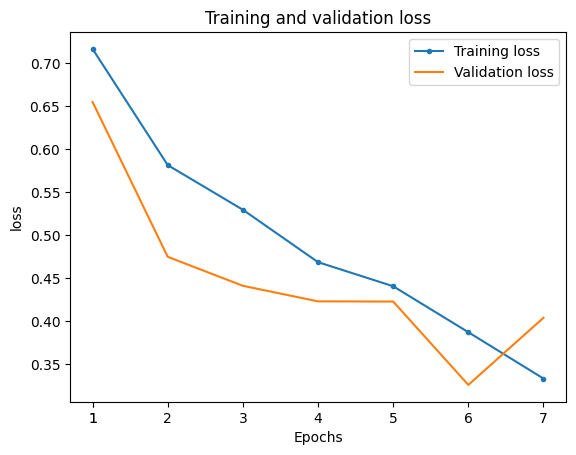

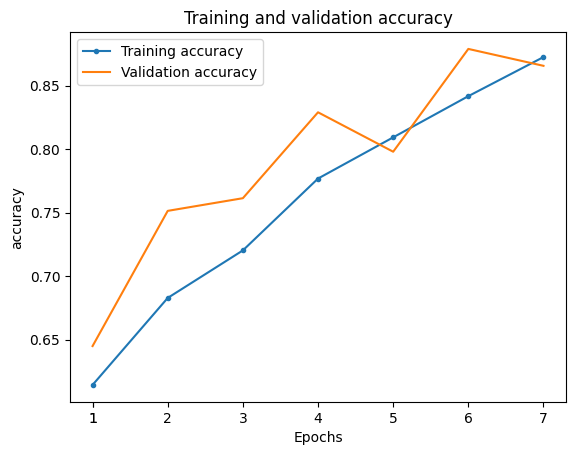


Eval scores:


2023-06-01 12:01:12.174549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


36/36 [==============================] - 2s 57ms/step - loss: 0.2935 - accuracy: 0.8758
================ best-CNN_layers-11_opt-Adam_lr-0.001_default ================
batch_size: 32 | epoch: 7
Time to train model: 278.63 sec
Time to eval model: 2.40 sec


In [29]:
trial1 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'default', 32, 7, 'Adam', 0.001)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 253, 253, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 251, 251, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 125, 125, 32)     0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 123, 123, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 59, 59, 128)      

2023-06-01 12:01:14.970335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


113/113 [==============================] - ETA: 0s - loss: 0.6158 - accuracy: 0.7094

2023-06-01 12:01:41.337676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.43039, saving model to best-CNN_layers-11_opt-Adam_lr-0.001_default.hdf5
113/113 [==============================] - 43s 323ms/step - loss: 0.6158 - accuracy: 0.7094 - val_loss: 0.4304 - val_accuracy: 0.7225
Epoch 2/7
113/113 [==============================] - ETA: 0s - loss: 0.4936 - accuracy: 0.7863
Epoch 2: val_loss improved from 0.43039 to 0.35921, saving model to best-CNN_layers-11_opt-Adam_lr-0.001_default.hdf5
113/113 [==============================] - 43s 317ms/step - loss: 0.4936 - accuracy: 0.7863 - val_loss: 0.3592 - val_accuracy: 0.8402
Epoch 3/7
113/113 [==============================] - ETA: 0s - loss: 0.4073 - accuracy: 0.8229
Epoch 3: val_loss improved from 0.35921 to 0.32223, saving model to best-CNN_layers-11_opt-Adam_lr-0.001_default.hdf5
113/113 [==============================] - 42s 305ms/step - loss: 0.4073 - accuracy: 0.8229 - val_loss: 0.3222 - val_accuracy: 0.8679
Epoch 4/7
113/113 [==============================] - ETA:

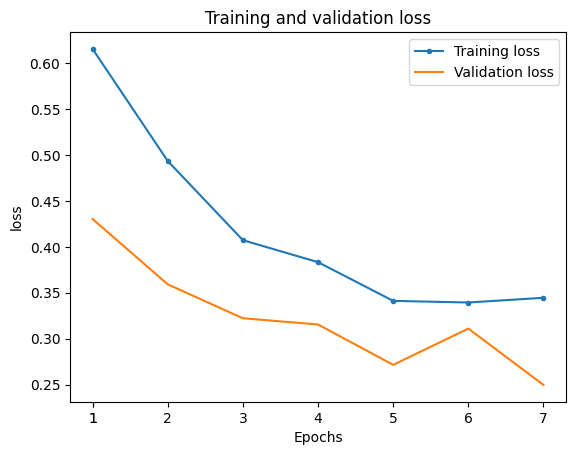

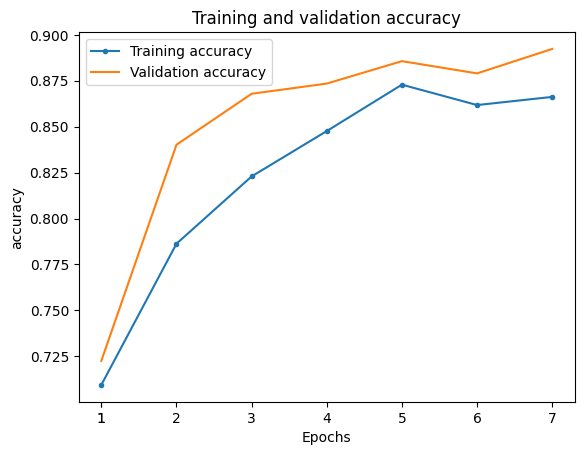


Eval scores:


2023-06-01 12:06:20.269714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


36/36 [==============================] - 2s 47ms/step - loss: 0.2244 - accuracy: 0.9059
================ best-CNN_layers-11_opt-Adam_lr-0.001_default ================
batch_size: 64 | epoch: 7
Time to train model: 304.67 sec
Time to eval model: 2.07 sec


In [30]:
trial2 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'default', 64, 7, 'Adam', 0.001)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 253, 253, 32)      896       
                                                                 
 conv2d_21 (Conv2D)          (None, 251, 251, 32)      9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 125, 125, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 123, 123, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 59, 59, 128)      

2023-06-01 12:10:09.968315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


113/113 [==============================] - ETA: 0s - loss: 0.6949 - accuracy: 0.6897

2023-06-01 12:10:38.253024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.36542, saving model to best-CNN_layers-11_opt-Adam_lr-0.001_default.hdf5
113/113 [==============================] - 51s 376ms/step - loss: 0.6949 - accuracy: 0.6897 - val_loss: 0.3654 - val_accuracy: 0.8368
Epoch 2/10
113/113 [==============================] - ETA: 0s - loss: 0.4979 - accuracy: 0.7905
Epoch 2: val_loss improved from 0.36542 to 0.36309, saving model to best-CNN_layers-11_opt-Adam_lr-0.001_default.hdf5
113/113 [==============================] - 45s 327ms/step - loss: 0.4979 - accuracy: 0.7905 - val_loss: 0.3631 - val_accuracy: 0.8524
Epoch 3/10
113/113 [==============================] - ETA: 0s - loss: 0.4492 - accuracy: 0.8107
Epoch 3: val_loss improved from 0.36309 to 0.35084, saving model to best-CNN_layers-11_opt-Adam_lr-0.001_default.hdf5
113/113 [==============================] - 45s 320ms/step - loss: 0.4492 - accuracy: 0.8107 - val_loss: 0.3508 - val_accuracy: 0.8457
Epoch 4/10
113/113 [==============================] - E

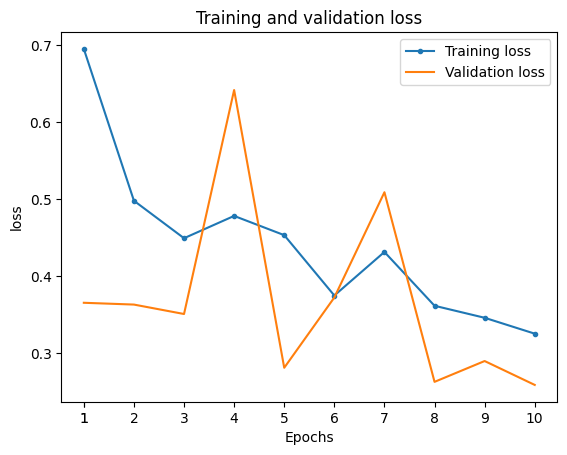

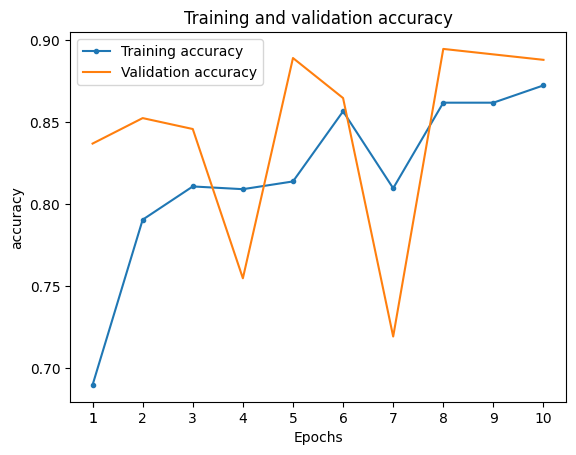


Eval scores:


2023-06-01 12:18:05.491158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


36/36 [==============================] - 2s 48ms/step - loss: 0.2189 - accuracy: 0.9290
================ best-CNN_layers-11_opt-Adam_lr-0.001_default ================
batch_size: 32 | epoch: 10
Time to train model: 474.75 sec
Time to eval model: 2.07 sec


In [32]:
trial3 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'default', 32, 10, 'Adam', 0.001)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 253, 253, 32)      896       
                                                                 
 conv2d_25 (Conv2D)          (None, 251, 251, 32)      9248      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 125, 125, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 123, 123, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 59, 59, 128)      

2023-06-01 12:20:18.461458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


113/113 [==============================] - ETA: 0s - loss: 4.3502 - accuracy: 0.4338

2023-06-01 12:20:49.296543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.76884, saving model to best-CNN_layers-11_opt-Adam_lr-0.01_default.hdf5
113/113 [==============================] - 53s 386ms/step - loss: 4.3502 - accuracy: 0.4338 - val_loss: 0.7688 - val_accuracy: 0.5383
Epoch 2/7
113/113 [==============================] - ETA: 0s - loss: 0.9401 - accuracy: 0.4832
Epoch 2: val_loss did not improve from 0.76884
113/113 [==============================] - 47s 337ms/step - loss: 0.9401 - accuracy: 0.4832 - val_loss: 1.0322 - val_accuracy: 0.4195
Epoch 3/7
113/113 [==============================] - ETA: 0s - loss: 1.5088 - accuracy: 0.2567
Epoch 3: val_loss did not improve from 0.76884
113/113 [==============================] - 53s 384ms/step - loss: 1.5088 - accuracy: 0.2567 - val_loss: 1.3800 - val_accuracy: 0.2775
Epoch 4/7
113/113 [==============================] - ETA: 0s - loss: 1.3814 - accuracy: 0.2601
Epoch 4: val_loss did not improve from 0.76884
113/113 [==============================] - 53s 380ms/step 

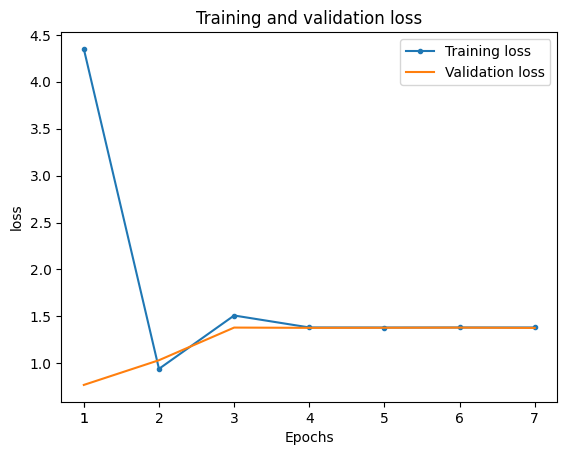

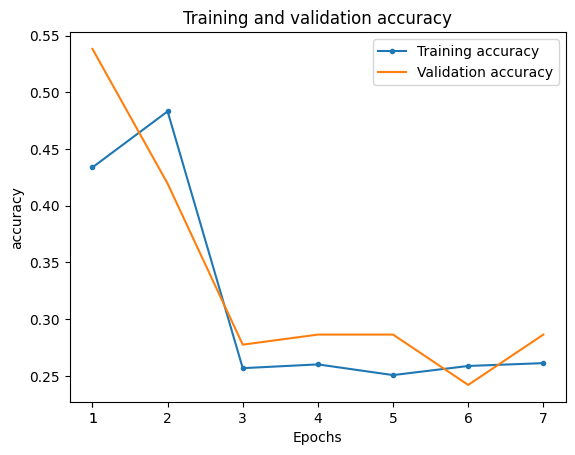


Eval scores:


2023-06-01 12:26:26.193541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


36/36 [==============================] - 2s 46ms/step - loss: 0.7552 - accuracy: 0.5546
================ best-CNN_layers-11_opt-Adam_lr-0.01_default ================
batch_size: 32 | epoch: 7
Time to train model: 366.40 sec
Time to eval model: 2.08 sec


In [33]:
trial4 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'default', 32, 7, 'Adam', 0.01)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 253, 253, 32)      896       
                                                                 
 conv2d_29 (Conv2D)          (None, 251, 251, 32)      9248      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 125, 125, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 123, 123, 64)      18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 59, 59, 128)      

2023-06-01 12:28:22.671874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


113/113 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.6681

2023-06-01 12:28:54.449069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.66501, saving model to best-CNN_layers-11_opt-Adam_lr-0.001_default.hdf5
113/113 [==============================] - 50s 354ms/step - loss: 0.6939 - accuracy: 0.6681 - val_loss: 0.6650 - val_accuracy: 0.6981
Epoch 2/10
113/113 [==============================] - ETA: 0s - loss: 0.4650 - accuracy: 0.8099
Epoch 2: val_loss improved from 0.66501 to 0.38955, saving model to best-CNN_layers-11_opt-Adam_lr-0.001_default.hdf5
113/113 [==============================] - 50s 353ms/step - loss: 0.4650 - accuracy: 0.8099 - val_loss: 0.3895 - val_accuracy: 0.8346
Epoch 3/10
113/113 [==============================] - ETA: 0s - loss: 0.4105 - accuracy: 0.8437
Epoch 3: val_loss improved from 0.38955 to 0.37042, saving model to best-CNN_layers-11_opt-Adam_lr-0.001_default.hdf5
113/113 [==============================] - 50s 358ms/step - loss: 0.4105 - accuracy: 0.8437 - val_loss: 0.3704 - val_accuracy: 0.8368
Epoch 4/10
113/113 [==============================] - E

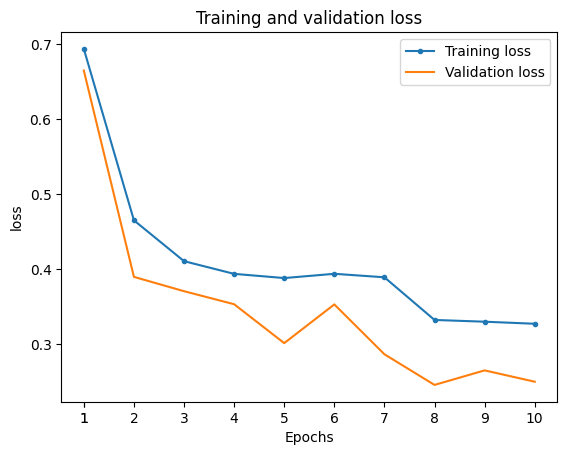

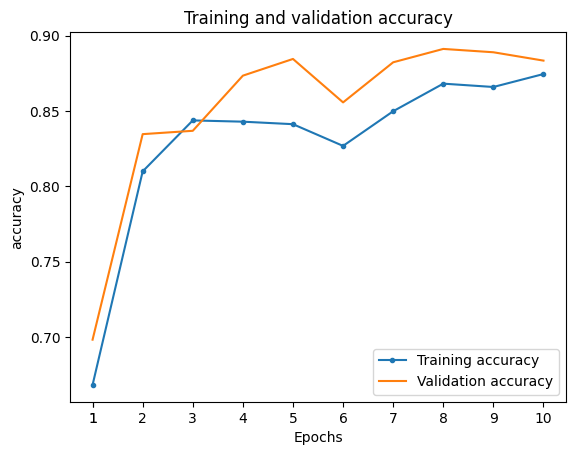


Eval scores:


2023-06-01 12:37:04.174391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


36/36 [==============================] - 2s 49ms/step - loss: 0.2398 - accuracy: 0.9086
================ best-CNN_layers-11_opt-Adam_lr-0.001_default ================
batch_size: 64 | epoch: 10
Time to train model: 520.83 sec
Time to eval model: 2.11 sec


In [34]:
trial5 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'default', 64, 10, 'Adam', 0.001)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 253, 253, 32)      896       
                                                                 
 conv2d_33 (Conv2D)          (None, 251, 251, 32)      9248      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 125, 125, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 123, 123, 64)      18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 59, 59, 128)      

2023-06-01 12:38:28.821939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


113/113 [==============================] - ETA: 0s - loss: 4.3746 - accuracy: 0.2673

2023-06-01 12:39:02.538783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 1.37861, saving model to best-CNN_layers-11_opt-Adam_lr-0.01_default.hdf5
113/113 [==============================] - 54s 370ms/step - loss: 4.3746 - accuracy: 0.2673 - val_loss: 1.3786 - val_accuracy: 0.2420
Epoch 2/7
113/113 [==============================] - ETA: 0s - loss: 1.3811 - accuracy: 0.2626
Epoch 2: val_loss improved from 1.37861 to 1.37816, saving model to best-CNN_layers-11_opt-Adam_lr-0.01_default.hdf5
113/113 [==============================] - 59s 422ms/step - loss: 1.3811 - accuracy: 0.2626 - val_loss: 1.3782 - val_accuracy: 0.2420
Epoch 3/7
113/113 [==============================] - ETA: 0s - loss: 1.3816 - accuracy: 0.2540
Epoch 3: val_loss improved from 1.37816 to 1.37716, saving model to best-CNN_layers-11_opt-Adam_lr-0.01_default.hdf5
113/113 [==============================] - 52s 368ms/step - loss: 1.3816 - accuracy: 0.2540 - val_loss: 1.3772 - val_accuracy: 0.2775
Epoch 4/7
113/113 [==============================] - ETA: 0s

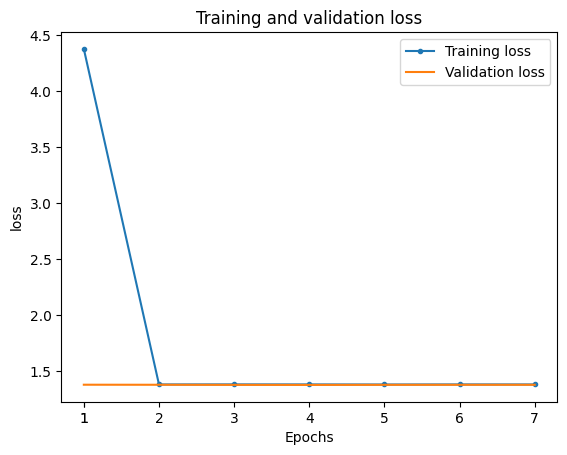

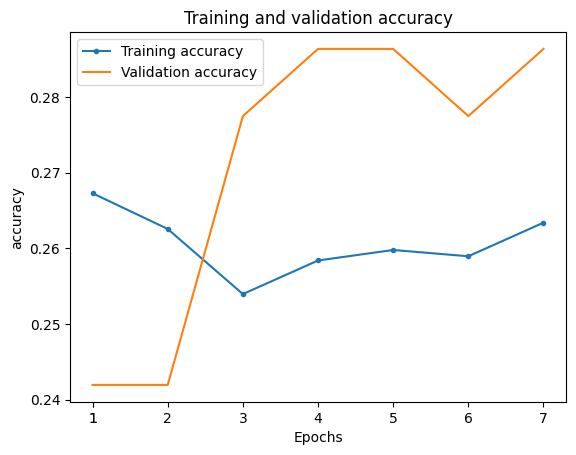


Eval scores:


2023-06-01 12:45:04.484685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


36/36 [==============================] - 2s 42ms/step - loss: 1.3806 - accuracy: 0.2555
================ best-CNN_layers-11_opt-Adam_lr-0.01_default ================
batch_size: 64 | epoch: 7
Time to train model: 395.14 sec
Time to eval model: 1.86 sec


In [35]:
trial6 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'default', 64, 7, 'Adam', 0.01)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 253, 253, 32)      896       
                                                                 
 conv2d_37 (Conv2D)          (None, 251, 251, 32)      9248      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 125, 125, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 123, 123, 64)      18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 59, 59, 128)      

2023-06-01 12:49:04.541986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


113/113 [==============================] - ETA: 0s - loss: 0.9766 - accuracy: 0.5543

2023-06-01 12:49:39.990835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.57400, saving model to best-CNN_layers-11_opt-RMSprop_lr-0.001_default.hdf5
113/113 [==============================] - 55s 377ms/step - loss: 0.9766 - accuracy: 0.5543 - val_loss: 0.5740 - val_accuracy: 0.6360
Epoch 2/7
113/113 [==============================] - ETA: 0s - loss: 0.6675 - accuracy: 0.6753
Epoch 2: val_loss improved from 0.57400 to 0.46738, saving model to best-CNN_layers-11_opt-RMSprop_lr-0.001_default.hdf5
113/113 [==============================] - 55s 381ms/step - loss: 0.6675 - accuracy: 0.6753 - val_loss: 0.4674 - val_accuracy: 0.7558
Epoch 3/7
113/113 [==============================] - ETA: 0s - loss: 0.6265 - accuracy: 0.6925
Epoch 3: val_loss did not improve from 0.46738
113/113 [==============================] - 55s 380ms/step - loss: 0.6265 - accuracy: 0.6925 - val_loss: 0.5610 - val_accuracy: 0.6859
Epoch 4/7
113/113 [==============================] - ETA: 0s - loss: 0.5743 - accuracy: 0.7560
Epoch 4: val_loss improved 

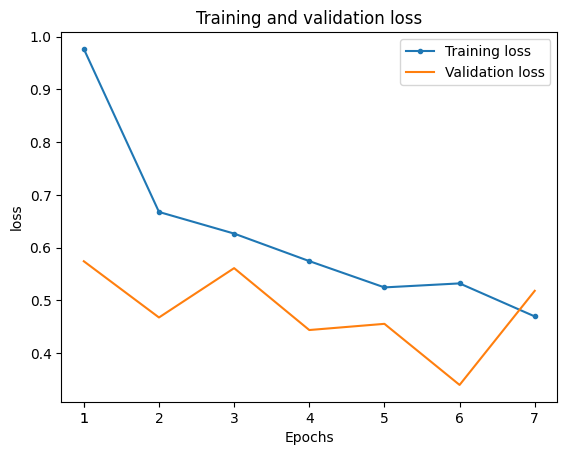

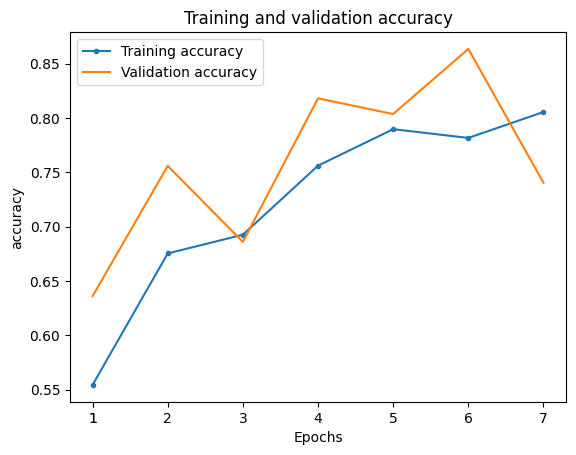


Eval scores:


2023-06-01 12:55:44.579647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


36/36 [==============================] - 2s 58ms/step - loss: 0.3429 - accuracy: 0.8696
================ best-CNN_layers-11_opt-RMSprop_lr-0.001_default ================
batch_size: 32 | epoch: 7
Time to train model: 399.53 sec
Time to eval model: 2.46 sec


In [36]:
trial9 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'default', 32, 7, 'RMSprop', 0.001)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 253, 253, 32)      896       
                                                                 
 conv2d_41 (Conv2D)          (None, 251, 251, 32)      9248      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 125, 125, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 123, 123, 64)      18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 59, 59, 128)     

2023-06-01 12:56:57.036441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


113/113 [==============================] - ETA: 0s - loss: 1.1662 - accuracy: 0.4732

2023-06-01 12:57:32.709818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.84858, saving model to best-CNN_layers-11_opt-RMSprop_lr-0.001_default.hdf5
113/113 [==============================] - 62s 446ms/step - loss: 1.1662 - accuracy: 0.4732 - val_loss: 0.8486 - val_accuracy: 0.4795
Epoch 2/7
113/113 [==============================] - ETA: 0s - loss: 0.8129 - accuracy: 0.6056
Epoch 2: val_loss improved from 0.84858 to 0.52829, saving model to best-CNN_layers-11_opt-RMSprop_lr-0.001_default.hdf5
113/113 [==============================] - 61s 445ms/step - loss: 0.8129 - accuracy: 0.6056 - val_loss: 0.5283 - val_accuracy: 0.6848
Epoch 3/7
113/113 [==============================] - ETA: 0s - loss: 0.6509 - accuracy: 0.7158
Epoch 3: val_loss did not improve from 0.52829
113/113 [==============================] - 62s 443ms/step - loss: 0.6509 - accuracy: 0.7158 - val_loss: 0.7258 - val_accuracy: 0.6515
Epoch 4/7
113/113 [==============================] - ETA: 0s - loss: 0.5844 - accuracy: 0.7349
Epoch 4: val_loss did not i

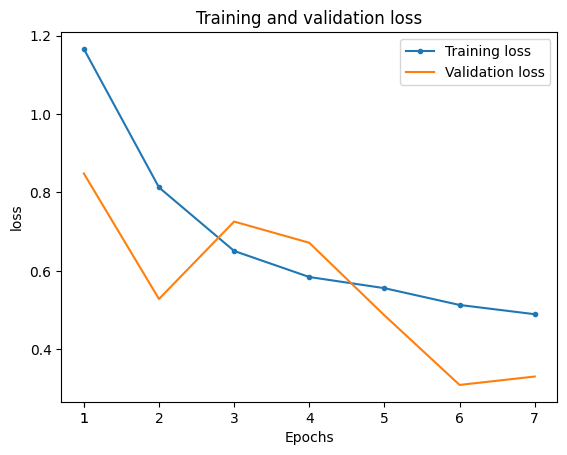

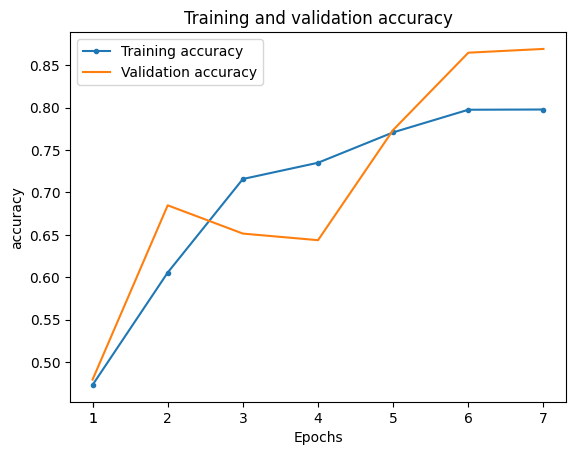


Eval scores:


2023-06-01 13:03:55.595724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


36/36 [==============================] - 2s 49ms/step - loss: 0.2990 - accuracy: 0.8731
================ best-CNN_layers-11_opt-RMSprop_lr-0.001_default ================
batch_size: 64 | epoch: 7
Time to train model: 418.05 sec
Time to eval model: 2.10 sec


In [37]:
trial10 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'default', 64, 7, 'RMSprop', 0.001)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 253, 253, 32)      896       
                                                                 
 conv2d_45 (Conv2D)          (None, 251, 251, 32)      9248      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 125, 125, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 123, 123, 64)      18496     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 59, 59, 128)     

2023-06-01 13:05:52.602774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


113/113 [==============================] - ETA: 0s - loss: 1.0199 - accuracy: 0.5881

2023-06-01 13:06:29.027179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.74657, saving model to best-CNN_layers-11_opt-RMSprop_lr-0.001_default.hdf5
113/113 [==============================] - 57s 392ms/step - loss: 1.0199 - accuracy: 0.5881 - val_loss: 0.7466 - val_accuracy: 0.6127
Epoch 2/10
113/113 [==============================] - ETA: 0s - loss: 0.6482 - accuracy: 0.7175
Epoch 2: val_loss improved from 0.74657 to 0.35524, saving model to best-CNN_layers-11_opt-RMSprop_lr-0.001_default.hdf5
113/113 [==============================] - 55s 379ms/step - loss: 0.6482 - accuracy: 0.7175 - val_loss: 0.3552 - val_accuracy: 0.8668
Epoch 3/10
113/113 [==============================] - ETA: 0s - loss: 0.5149 - accuracy: 0.7866
Epoch 3: val_loss did not improve from 0.35524
113/113 [==============================] - 55s 381ms/step - loss: 0.5149 - accuracy: 0.7866 - val_loss: 0.6084 - val_accuracy: 0.6837
Epoch 4/10
113/113 [==============================] - ETA: 0s - loss: 0.4922 - accuracy: 0.7918
Epoch 4: val_loss did no

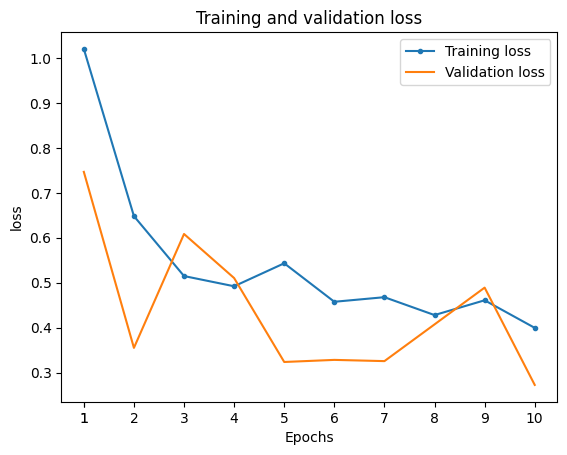

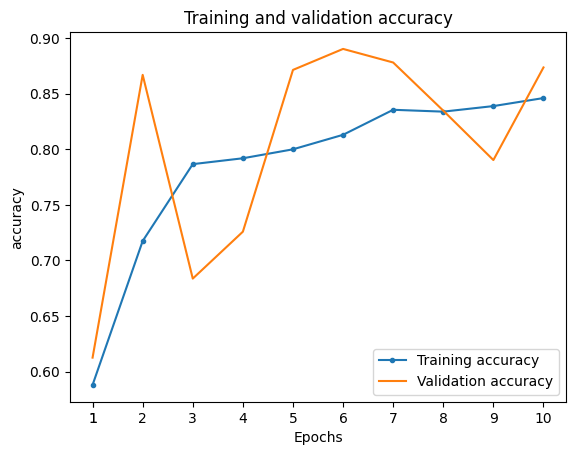


Eval scores:


2023-06-01 13:15:57.369167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


36/36 [==============================] - 2s 39ms/step - loss: 0.2510 - accuracy: 0.8953
================ best-CNN_layers-11_opt-RMSprop_lr-0.001_default ================
batch_size: 32 | epoch: 10
Time to train model: 604.31 sec
Time to eval model: 1.74 sec


In [38]:
trial11 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'default', 32, 10, 'RMSprop', 0.001)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 253, 253, 32)      896       
                                                                 
 conv2d_49 (Conv2D)          (None, 251, 251, 32)      9248      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 125, 125, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 123, 123, 64)      18496     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 59, 59, 128)     

2023-06-01 13:16:35.576951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


113/113 [==============================] - ETA: 0s - loss: 66.4387 - accuracy: 0.2803

2023-06-01 13:17:12.914977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 1.37969, saving model to best-CNN_layers-11_opt-RMSprop_lr-0.01_default.hdf5
113/113 [==============================] - 67s 474ms/step - loss: 66.4387 - accuracy: 0.2803 - val_loss: 1.3797 - val_accuracy: 0.2420
Epoch 2/7
113/113 [==============================] - ETA: 0s - loss: 1.3816 - accuracy: 0.2617
Epoch 2: val_loss improved from 1.37969 to 1.37868, saving model to best-CNN_layers-11_opt-RMSprop_lr-0.01_default.hdf5
113/113 [==============================] - 64s 458ms/step - loss: 1.3816 - accuracy: 0.2617 - val_loss: 1.3787 - val_accuracy: 0.2775
Epoch 3/7
113/113 [==============================] - ETA: 0s - loss: 1.3808 - accuracy: 0.2712
Epoch 3: val_loss did not improve from 1.37868
113/113 [==============================] - 63s 449ms/step - loss: 1.3808 - accuracy: 0.2712 - val_loss: 1.3812 - val_accuracy: 0.2420
Epoch 4/7
113/113 [==============================] - ETA: 0s - loss: 1.3809 - accuracy: 0.2601
Epoch 4: val_loss improved f

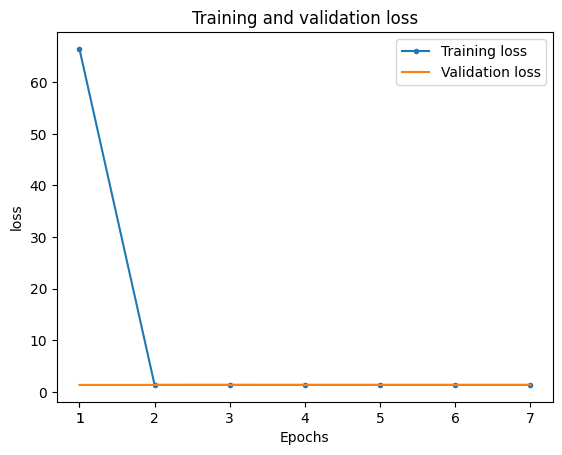

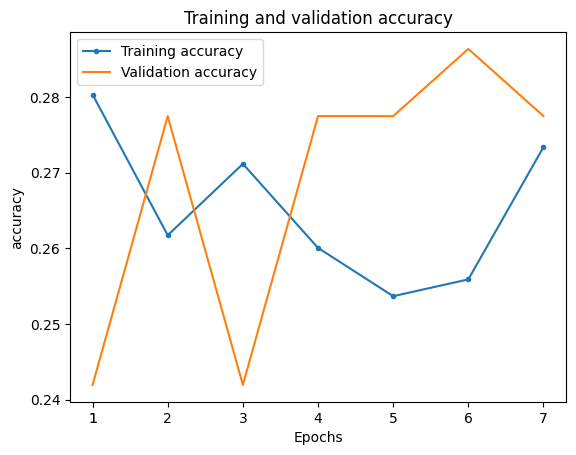


Eval scores:


2023-06-01 13:23:56.932576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


36/36 [==============================] - 2s 47ms/step - loss: 1.3815 - accuracy: 0.2555
================ best-CNN_layers-11_opt-RMSprop_lr-0.01_default ================
batch_size: 32 | epoch: 7
Time to train model: 440.86 sec
Time to eval model: 2.05 sec


In [39]:
trial12 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'default', 32, 7, 'RMSprop', 0.01)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 253, 253, 32)      896       
                                                                 
 conv2d_53 (Conv2D)          (None, 251, 251, 32)      9248      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 125, 125, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 123, 123, 64)      18496     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (None, 59, 59, 128)     

2023-06-01 13:24:46.380435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


113/113 [==============================] - ETA: 0s - loss: 1.0443 - accuracy: 0.4979

2023-06-01 13:25:23.838031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.78568, saving model to best-CNN_layers-11_opt-RMSprop_lr-0.001_default.hdf5
113/113 [==============================] - 58s 396ms/step - loss: 1.0443 - accuracy: 0.4979 - val_loss: 0.7857 - val_accuracy: 0.5339
Epoch 2/10
113/113 [==============================] - ETA: 0s - loss: 0.7195 - accuracy: 0.6409
Epoch 2: val_loss improved from 0.78568 to 0.47195, saving model to best-CNN_layers-11_opt-RMSprop_lr-0.001_default.hdf5
113/113 [==============================] - 58s 399ms/step - loss: 0.7195 - accuracy: 0.6409 - val_loss: 0.4719 - val_accuracy: 0.7669
Epoch 3/10
113/113 [==============================] - ETA: 0s - loss: 0.6252 - accuracy: 0.7161
Epoch 3: val_loss did not improve from 0.47195
113/113 [==============================] - 65s 462ms/step - loss: 0.6252 - accuracy: 0.7161 - val_loss: 0.5145 - val_accuracy: 0.7880
Epoch 4/10
113/113 [==============================] - ETA: 0s - loss: 0.6177 - accuracy: 0.7330
Epoch 4: val_loss improv

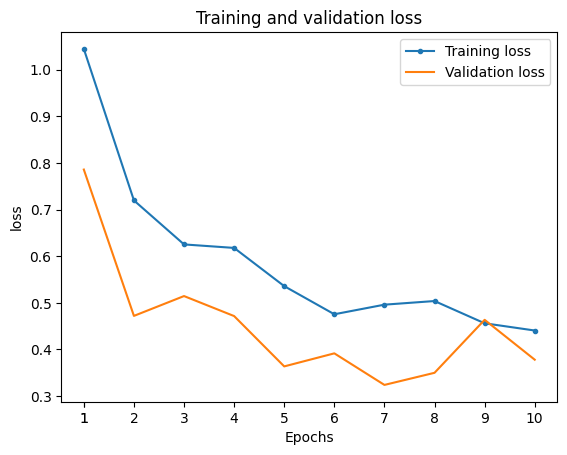

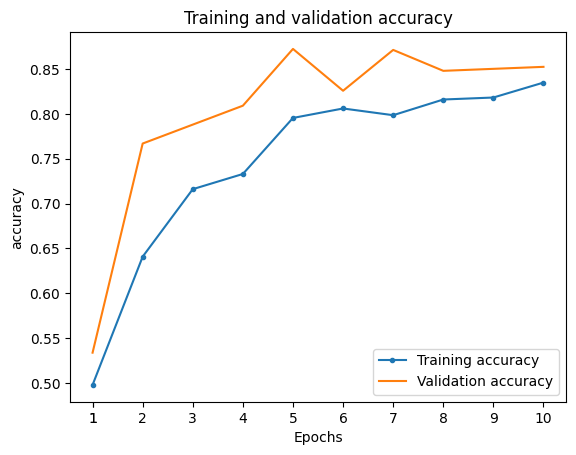


Eval scores:


2023-06-01 13:35:02.878821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


36/36 [==============================] - 2s 60ms/step - loss: 0.3007 - accuracy: 0.8953
================ best-CNN_layers-11_opt-RMSprop_lr-0.001_default ================
batch_size: 64 | epoch: 10
Time to train model: 615.97 sec
Time to eval model: 2.52 sec


In [40]:
trial13 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'default', 64, 10, 'RMSprop', 0.001)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 253, 253, 32)      896       
                                                                 
 conv2d_57 (Conv2D)          (None, 251, 251, 32)      9248      
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 125, 125, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 123, 123, 64)      18496     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 59, 59, 128)     

2023-06-01 13:37:16.360855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


113/113 [==============================] - ETA: 0s - loss: 1.3108 - accuracy: 0.2956

2023-06-01 13:37:54.536440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 1.21972, saving model to best-CNN_layers-11_opt-SGD_lr-0.001_default.hdf5
113/113 [==============================] - 59s 401ms/step - loss: 1.3108 - accuracy: 0.2956 - val_loss: 1.2197 - val_accuracy: 0.4295
Epoch 2/7
113/113 [==============================] - ETA: 0s - loss: 1.0689 - accuracy: 0.5273
Epoch 2: val_loss improved from 1.21972 to 0.90874, saving model to best-CNN_layers-11_opt-SGD_lr-0.001_default.hdf5
113/113 [==============================] - 67s 483ms/step - loss: 1.0689 - accuracy: 0.5273 - val_loss: 0.9087 - val_accuracy: 0.5516
Epoch 3/7
113/113 [==============================] - ETA: 0s - loss: 0.8085 - accuracy: 0.6137
Epoch 3: val_loss improved from 0.90874 to 0.68358, saving model to best-CNN_layers-11_opt-SGD_lr-0.001_default.hdf5
113/113 [==============================] - 58s 400ms/step - loss: 0.8085 - accuracy: 0.6137 - val_loss: 0.6836 - val_accuracy: 0.6115
Epoch 4/7
113/113 [==============================] - ETA: 0s

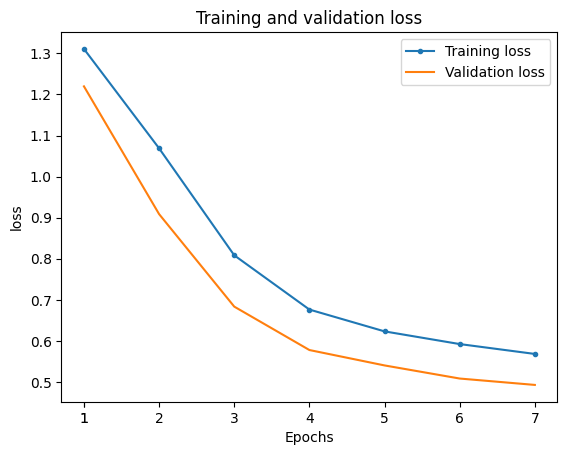

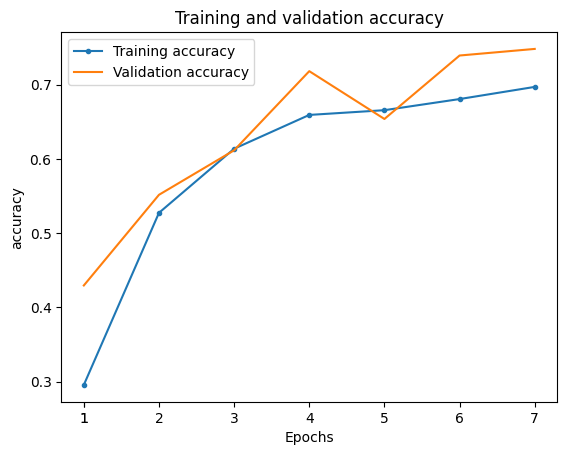


Eval scores:


2023-06-01 13:44:27.130646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


36/36 [==============================] - 2s 48ms/step - loss: 0.4695 - accuracy: 0.7666
================ best-CNN_layers-11_opt-SGD_lr-0.001_default ================
batch_size: 32 | epoch: 7
Time to train model: 430.51 sec
Time to eval model: 2.06 sec


In [41]:
trial17 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'default', 32, 7, 'SGD', 0.001)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 253, 253, 32)      896       
                                                                 
 conv2d_61 (Conv2D)          (None, 251, 251, 32)      9248      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 125, 125, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 123, 123, 64)      18496     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (None, 59, 59, 128)     

2023-06-01 13:45:12.943098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


113/113 [==============================] - ETA: 0s - loss: 1.3181 - accuracy: 0.2617

2023-06-01 13:45:51.562203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 1.28434, saving model to best-CNN_layers-11_opt-SGD_lr-0.001_default.hdf5
113/113 [==============================] - 69s 490ms/step - loss: 1.3181 - accuracy: 0.2617 - val_loss: 1.2843 - val_accuracy: 0.2420
Epoch 2/10
113/113 [==============================] - ETA: 0s - loss: 1.2074 - accuracy: 0.3483
Epoch 2: val_loss improved from 1.28434 to 1.14379, saving model to best-CNN_layers-11_opt-SGD_lr-0.001_default.hdf5
113/113 [==============================] - 59s 403ms/step - loss: 1.2074 - accuracy: 0.3483 - val_loss: 1.1438 - val_accuracy: 0.4961
Epoch 3/10
113/113 [==============================] - ETA: 0s - loss: 1.0689 - accuracy: 0.5232
Epoch 3: val_loss improved from 1.14379 to 0.98215, saving model to best-CNN_layers-11_opt-SGD_lr-0.001_default.hdf5
113/113 [==============================] - 61s 417ms/step - loss: 1.0689 - accuracy: 0.5232 - val_loss: 0.9822 - val_accuracy: 0.5949
Epoch 4/10
113/113 [==============================] - ETA:

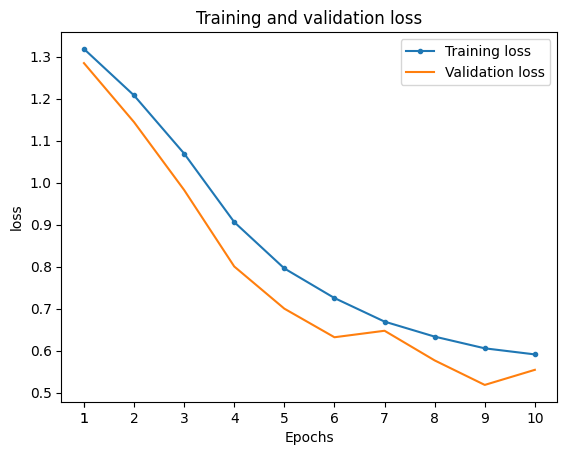

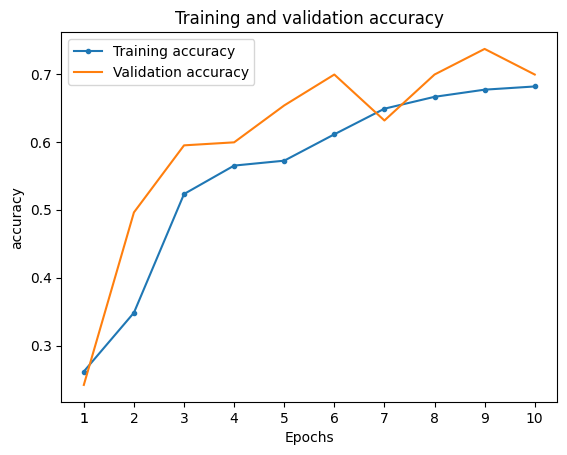


Eval scores:


2023-06-01 13:55:52.435776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


36/36 [==============================] - 2s 46ms/step - loss: 0.4983 - accuracy: 0.7640
================ best-CNN_layers-11_opt-SGD_lr-0.001_default ================
batch_size: 32 | epoch: 10
Time to train model: 639.10 sec
Time to eval model: 2.04 sec


In [42]:
trial18 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'default', 32, 10, 'SGD', 0.001)

In [58]:
def model_CNN():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=(255, 255, 3), activation='relu'))  # Increase the number of filters
    model.add(BatchNormalization())  # Add Batch Normalization layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, (3, 3), activation='relu'))  # Increase the number of filters
    model.add(BatchNormalization())  # Add Batch Normalization layer
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(256, (3, 3), activation='relu'))  # Increase the number of filters
    model.add(MaxPooling2D(2, 2))
#     model.add(Flatten())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))  # Increase the number of neurons in the Dense layer
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))  # Add an extra Dense layer
    model.add(Dense(4, activation='softmax'))
    return model

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_77 (Conv2D)          (None, 253, 253, 64)      1792      
                                                                 
 batch_normalization_6 (Batc  (None, 253, 253, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_78 (Conv2D)          (None, 251, 251, 64)      36928     
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 125, 125, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_79 (Conv2D)          (None, 123, 123, 128)     73856     
                                                                 
 batch_normalization_7 (Batc  (None, 123, 123, 128)  

2023-06-01 22:13:20.471087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


113/113 [==============================] - ETA: 0s - loss: 7.9628 - accuracy: 0.6017

2023-06-01 22:14:32.017072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 2.64579, saving model to best-CNN_layers-14_opt-Adam_lr-0.001_more_complex_with_flatten.hdf5
113/113 [==============================] - 105s 743ms/step - loss: 7.9628 - accuracy: 0.6017 - val_loss: 2.6458 - val_accuracy: 0.2320
Epoch 2/10
113/113 [==============================] - ETA: 0s - loss: 0.9325 - accuracy: 0.5418
Epoch 2: val_loss improved from 2.64579 to 1.54882, saving model to best-CNN_layers-14_opt-Adam_lr-0.001_more_complex_with_flatten.hdf5
113/113 [==============================] - 92s 699ms/step - loss: 0.9325 - accuracy: 0.5418 - val_loss: 1.5488 - val_accuracy: 0.2420
Epoch 3/10
113/113 [==============================] - ETA: 0s - loss: 0.8157 - accuracy: 0.6234
Epoch 3: val_loss improved from 1.54882 to 1.07642, saving model to best-CNN_layers-14_opt-Adam_lr-0.001_more_complex_with_flatten.hdf5
113/113 [==============================] - 92s 698ms/step - loss: 0.8157 - accuracy: 0.6234 - val_loss: 1.0764 - val_accuracy: 0.5094


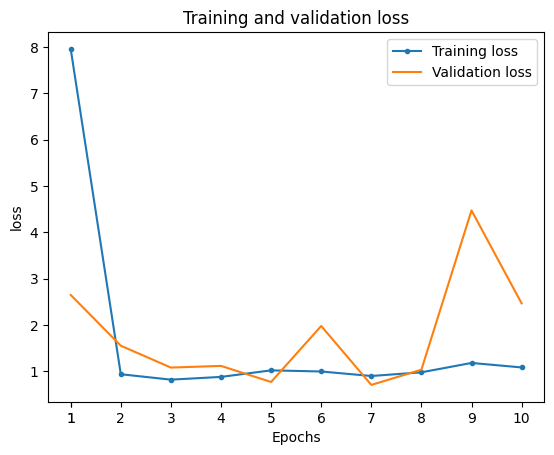

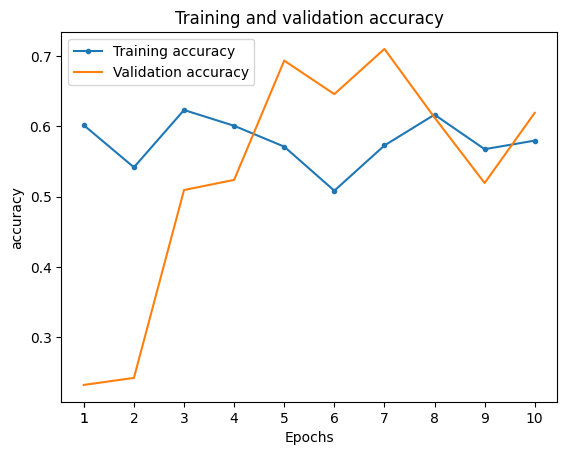


Eval scores:


2023-06-01 22:28:44.447877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


36/36 [==============================] - 4s 95ms/step - loss: 0.6566 - accuracy: 0.7374
================ best-CNN_layers-14_opt-Adam_lr-0.001_more_complex_with_flatten ================
batch_size: 32 | epoch: 10
Time to train model: 919.88 sec
Time to eval model: 3.84 sec


In [57]:
trial19 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'more_complex_with_flatten', 32, 10, 'Adam', 0.001)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_81 (Conv2D)          (None, 253, 253, 64)      1792      
                                                                 
 batch_normalization_8 (Batc  (None, 253, 253, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_82 (Conv2D)          (None, 251, 251, 64)      36928     
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 125, 125, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_83 (Conv2D)          (None, 123, 123, 128)     73856     
                                                                 
 batch_normalization_9 (Batc  (None, 123, 123, 128)  

2023-06-01 22:38:34.090846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


113/113 [==============================] - ETA: 0s - loss: 0.5167 - accuracy: 0.7963

2023-06-01 22:39:32.209559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 2.06460, saving model to best-CNN_layers-14_opt-Adam_lr-0.001_more_complex_with_GlobalAveragePooling2D.hdf5
113/113 [==============================] - 80s 587ms/step - loss: 0.5167 - accuracy: 0.7963 - val_loss: 2.0646 - val_accuracy: 0.4362
Epoch 2/10
113/113 [==============================] - ETA: 0s - loss: 0.4219 - accuracy: 0.8365
Epoch 2: val_loss did not improve from 2.06460
113/113 [==============================] - 78s 576ms/step - loss: 0.4219 - accuracy: 0.8365 - val_loss: 2.7418 - val_accuracy: 0.5216
Epoch 3/10
113/113 [==============================] - ETA: 0s - loss: 0.3807 - accuracy: 0.8512
Epoch 3: val_loss improved from 2.06460 to 1.85187, saving model to best-CNN_layers-14_opt-Adam_lr-0.001_more_complex_with_GlobalAveragePooling2D.hdf5
113/113 [==============================] - 79s 585ms/step - loss: 0.3807 - accuracy: 0.8512 - val_loss: 1.8519 - val_accuracy: 0.4351
Epoch 4/10
113/113 [==============================] - ETA: 0

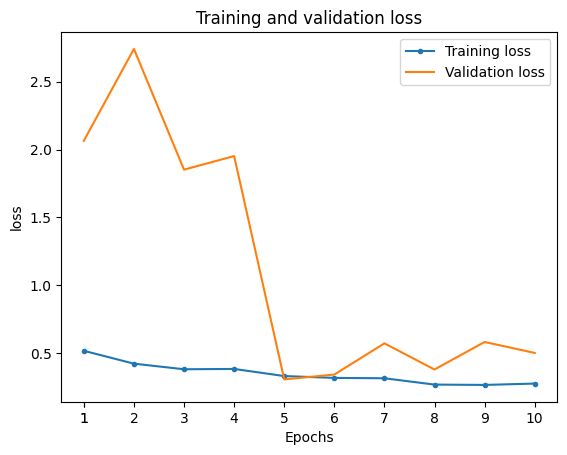

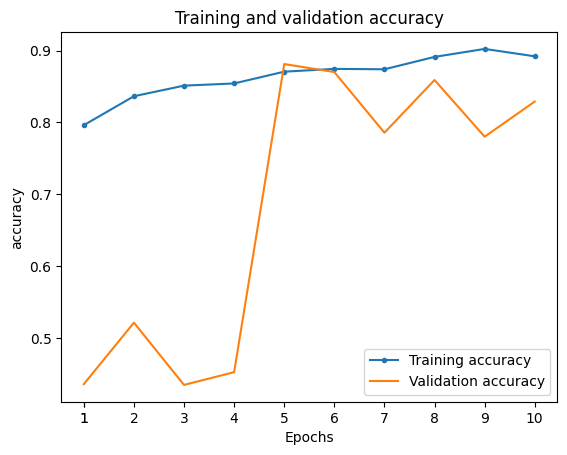


Eval scores:


2023-06-01 22:52:23.042278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


36/36 [==============================] - 3s 73ms/step - loss: 0.2748 - accuracy: 0.8988
================ best-CNN_layers-14_opt-Adam_lr-0.001_more_complex_with_GlobalAveragePooling2D ================
batch_size: 32 | epoch: 10
Time to train model: 828.66 sec
Time to eval model: 3.01 sec


In [59]:
trial20 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'more_complex_with_GlobalAveragePooling2D', 32, 10, 'Adam', 0.001)

In [12]:
history = model.fit(train_generator, validation_data=valid_generator, epochs=5, callbacks=[checkpoint],
                    use_multiprocessing=True, workers=mp.cpu_count())

Epoch 1/5


2023-05-30 21:42:35.990361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-30 21:42:41.665069: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-30 21:42:43.747763: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x565230c15bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-30 21:42:43.747807: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-05-30 21:42:43.747816: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2023-05-30 21:42:43.747824: I tensorflow/compiler/xla/service/service.cc:177]   Str

141/141 [==============================] - ETA: 0s - loss: 0.6446 - accuracy: 0.6723

2023-05-30 21:43:06.883115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.62314, saving model to best-CNN.hdf5
141/141 [==============================] - 44s 231ms/step - loss: 0.6446 - accuracy: 0.6723 - val_loss: 0.6231 - val_accuracy: 0.7471
Epoch 2/5
141/141 [==============================] - ETA: 0s - loss: 0.5223 - accuracy: 0.7562
Epoch 2: val_loss improved from 0.62314 to 0.49568, saving model to best-CNN.hdf5
141/141 [==============================] - 36s 226ms/step - loss: 0.5223 - accuracy: 0.7562 - val_loss: 0.4957 - val_accuracy: 0.7320
Epoch 3/5
141/141 [==============================] - ETA: 0s - loss: 0.4345 - accuracy: 0.8062
Epoch 3: val_loss improved from 0.49568 to 0.31094, saving model to best-CNN.hdf5
141/141 [==============================] - 37s 224ms/step - loss: 0.4345 - accuracy: 0.8062 - val_loss: 0.3109 - val_accuracy: 0.8687
Epoch 4/5
141/141 [==============================] - ETA: 0s - loss: 0.3753 - accuracy: 0.8410
Epoch 4: val_loss improved from 0.31094 to 0.29391, saving model to be

In [14]:
num_samples = test_df.shape[0]
num_samples

1127

In [17]:
model = load_model(checkpoint_name)
score = model.evaluate(test_generator, steps=num_samples // 32 + 1)

2023-05-30 21:46:06.148929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


36/36 [==============================] - 2s 59ms/step - loss: 0.2734 - accuracy: 0.8767


In [56]:
score

[0.273355633020401, 0.8766636848449707]

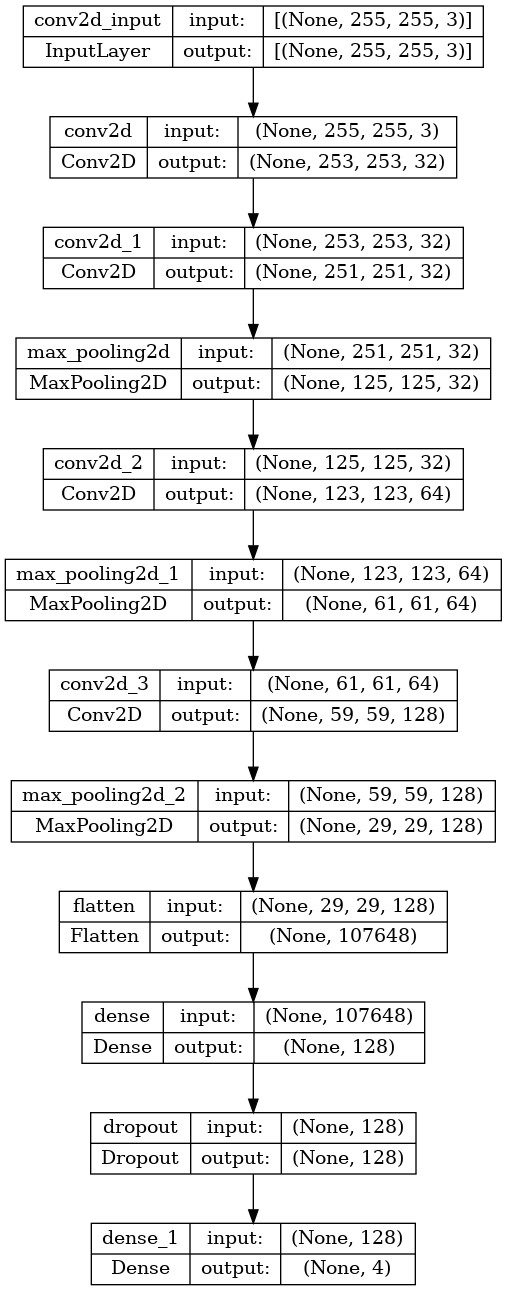

In [10]:
from tensorflow.keras.utils import plot_model
from PIL import Image

plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)
display(Image.open('cnn_model.png'))

# Loss & Accuracy Visualizations

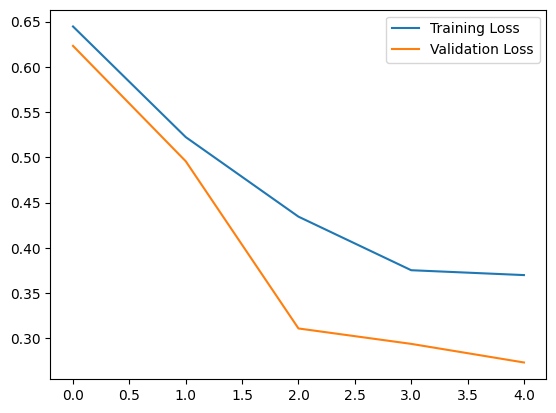

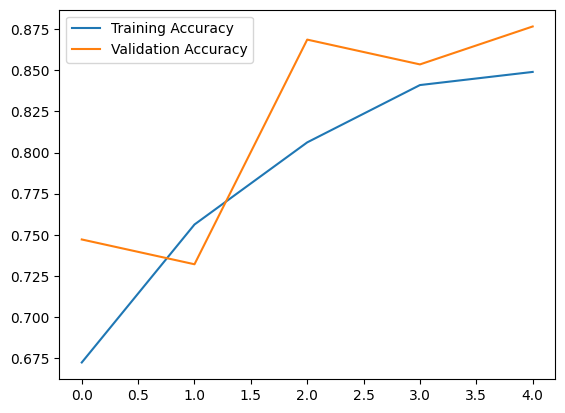

<Figure size 640x480 with 0 Axes>

In [18]:
# Plot the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# Plot the accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

# Saving Our Model

In [19]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the class names
class_names = ['Cloudy', 'Desert', 'Green_Area', 'Water']

In [21]:
# Load an image from the test set
img = load_img(DATA_DIR / "green_area" / "Forest_1768.jpg", target_size=(255, 255))

In [22]:
# Convert the image to an array
img_array = img_to_array(img)
img_array

array([[[33., 60., 69.],
        [33., 60., 69.],
        [33., 60., 69.],
        ...,
        [38., 65., 72.],
        [38., 65., 72.],
        [38., 65., 72.]],

       [[33., 60., 69.],
        [33., 60., 69.],
        [33., 60., 69.],
        ...,
        [38., 65., 72.],
        [38., 65., 72.],
        [38., 65., 72.]],

       [[33., 60., 69.],
        [33., 60., 69.],
        [33., 60., 69.],
        ...,
        [38., 65., 72.],
        [38., 65., 72.],
        [38., 65., 72.]],

       ...,

       [[33., 57., 67.],
        [33., 57., 67.],
        [33., 57., 67.],
        ...,
        [31., 58., 65.],
        [31., 58., 65.],
        [31., 58., 65.]],

       [[33., 57., 67.],
        [33., 57., 67.],
        [33., 57., 67.],
        ...,
        [31., 58., 65.],
        [31., 58., 65.],
        [31., 58., 65.]],

       [[33., 57., 67.],
        [33., 57., 67.],
        [33., 57., 67.],
        ...,
        [31., 58., 65.],
        [31., 58., 65.],
        [31., 58., 65.]]

In [23]:
img_array.shape

(255, 255, 3)

In [24]:
# Normalize the image pixel values to the range [0, 1]
img_array = img_array / 255.0
img_array

array([[[0.12941177, 0.23529412, 0.27058825],
        [0.12941177, 0.23529412, 0.27058825],
        [0.12941177, 0.23529412, 0.27058825],
        ...,
        [0.14901961, 0.25490198, 0.28235295],
        [0.14901961, 0.25490198, 0.28235295],
        [0.14901961, 0.25490198, 0.28235295]],

       [[0.12941177, 0.23529412, 0.27058825],
        [0.12941177, 0.23529412, 0.27058825],
        [0.12941177, 0.23529412, 0.27058825],
        ...,
        [0.14901961, 0.25490198, 0.28235295],
        [0.14901961, 0.25490198, 0.28235295],
        [0.14901961, 0.25490198, 0.28235295]],

       [[0.12941177, 0.23529412, 0.27058825],
        [0.12941177, 0.23529412, 0.27058825],
        [0.12941177, 0.23529412, 0.27058825],
        ...,
        [0.14901961, 0.25490198, 0.28235295],
        [0.14901961, 0.25490198, 0.28235295],
        [0.14901961, 0.25490198, 0.28235295]],

       ...,

       [[0.12941177, 0.22352941, 0.2627451 ],
        [0.12941177, 0.22352941, 0.2627451 ],
        [0.12941177, 0

In [25]:
import numpy as np
img_array = np.reshape(img_array, (1, 255, 255, 3))

# Using Our Model For Predictions

In [26]:
# Get the model predictions
predictions = model.predict(img_array)

1/1 [==============================] - 0s 327ms/step


In [27]:
# Get the class index with the highest predicted probability
class_index = np.argmax(predictions[0])

# Get the predicted class label
predicted_label = class_names[class_index]

print("The image is predicted to be '{}'.".format(predicted_label))

The image is predicted to be 'Green_Area'.


In [28]:
from sklearn.metrics import confusion_matrix
import numpy as np

In [30]:
predictions = model.predict(test_generator)

 2/36 [>.............................] - ETA: 1s

2023-05-30 21:50:54.326078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


36/36 [==============================] - 2s 51ms/step


In [31]:
predictions

array([[5.6263834e-02, 9.4373614e-01, 5.0946738e-14, 8.4413032e-12],
       [2.1677979e-03, 2.7604994e-05, 7.6027167e-01, 2.3753296e-01],
       [1.0300012e-03, 8.9875230e-06, 7.1657145e-01, 2.8238961e-01],
       ...,
       [5.2434792e-05, 1.7438178e-07, 3.0648935e-01, 6.9345808e-01],
       [9.8536772e-01, 1.4628706e-02, 1.2989366e-09, 3.5105311e-06],
       [9.8341310e-01, 1.6578827e-02, 6.1684711e-09, 8.0999753e-06]],
      dtype=float32)

In [32]:
actual_labels = test_generator.classes

In [33]:
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

array([1, 2, 2, ..., 3, 0, 0])

In [34]:
cm = confusion_matrix(actual_labels, predicted_labels)

In [35]:
print(cm)

[[87 83 93 65]
 [61 62 56 48]
 [72 52 94 66]
 [72 74 85 57]]


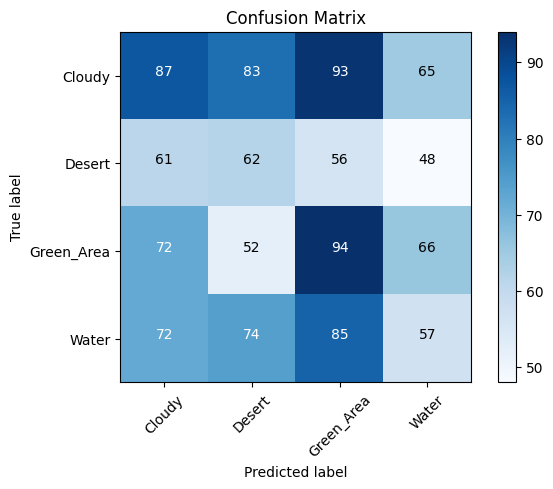

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Confusion matrix


# Plot the confusion matrix as an image
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Add the class labels to the plot
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add values to the plot
threshold = int(cm.mean())
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black")

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

# Advanced Predictions From URLs

In [38]:
from io import BytesIO
import requests
from tensorflow.keras.preprocessing import image
import numpy as np
import tempfile

# Define the class names
class_names = ['Cloudy', 'Desert', 'Green_Area', 'Water']

url_list = ['https://eoimages.gsfc.nasa.gov/images/imagerecords/92000/92263/goldstone_oli_2018124_lrg.jpg',
            'https://images.theconversation.com/files/258323/original/file-20190211-174861-jya1so.jpg?ixlib=rb-1.1.0&q=45&auto=format&w=1356&h=668&fit=crop',
            'https://img.freepik.com/free-photo/amazing-beautiful-sky-with-clouds_58702-1657.jpg?w=2000',
            'https://i.natgeofe.com/n/54c007c9-50e5-4cf5-83dc-978a35a4373a/68576_16x9.jpg',
           ]


for url in url_list:
    response = requests.get(url)
    with tempfile.NamedTemporaryFile(mode='wb') as f:
        f.write(response.content)
        f.seek(0)
        img = image.load_img(f.name, target_size=(255, 255))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)

        classes = model.predict(img, batch_size=10)
        class_index = np.argmax(classes[0])
        predicted_label = class_names[class_index]
        print(url + " The image is predicted to be '{}'.".format(predicted_label))


1/1 [==============================] - 0s 39ms/step
https://eoimages.gsfc.nasa.gov/images/imagerecords/92000/92263/goldstone_oli_2018124_lrg.jpg The image is predicted to be 'Desert'.
1/1 [==============================] - 0s 39ms/step
https://images.theconversation.com/files/258323/original/file-20190211-174861-jya1so.jpg?ixlib=rb-1.1.0&q=45&auto=format&w=1356&h=668&fit=crop The image is predicted to be 'Water'.
1/1 [==============================] - 0s 38ms/step
https://img.freepik.com/free-photo/amazing-beautiful-sky-with-clouds_58702-1657.jpg?w=2000 The image is predicted to be 'Desert'.
1/1 [==============================] - 0s 38ms/step
https://i.natgeofe.com/n/54c007c9-50e5-4cf5-83dc-978a35a4373a/68576_16x9.jpg The image is predicted to be 'Desert'.


# Table of results

In [60]:
df_res = pd.DataFrame(columns=trials[0].keys())
trials = [
    trial1, trial2, trial3, trial4, trial5, trial6, 
    trial9, trial10, trial11, trial12, trial13,
    trial17, trial18,
    trial19, trial20
]

for trial in trials:
    df_res.loc[len(df_res)] = trial

df_res = df_res.sort_values(by=['accuracy', 'loss', 'time_train', 'time_eval'], ascending=[False, True, True, True])
df_res

,optimizer,lr,loss,accuracy,batch_size,epochs,nn_architecture,time_eval,time_train
2,Adam,0.001,0.218853,0.929015,32,10,default,2.069458,474.752395
4,Adam,0.001,0.239828,0.908607,64,10,default,2.112470,520.832322
1,Adam,0.001,0.224355,0.905945,64,7,default,2.073179,304.666910
14,Adam,0.001,0.274789,0.898847,32,10,more_complex_with_GlobalAveragePooling2D,3.008237,828.658589
8,RMSprop,0.001,0.250980,0.895297,32,10,default,1.744878,604.312080
10,RMSprop,0.001,0.300684,0.895297,64,10,default,2.519724,615.971445
0,Adam,0.001,0.293526,0.875776,32,7,default,2.401112,278.627155
7,RMSprop,0.001,0.299018,0.873114,64,7,default,2.103976,418.052669
6,RMSprop,0.001,0.342912,0.869565,32,7,default,2.460535,399.530920
11,SGD,0.001,0.469539,0.766637,32,7,default,2.063300,430.507702
